Visualizing Word2Vec results

In [1]:
import os
import json
from pprint import pprint
import random
import numpy as np
from matplotlib import pyplot as plt


DATA_PATH = r"data\nyt_crosswords-cleaned"
puzzles_available = []

for year in os.listdir(DATA_PATH):
    if not year.isdecimal(): continue       # skip README.md
    for month in os.listdir(os.path.join(DATA_PATH, year)):
        for day in os.listdir(os.path.join(DATA_PATH, year, month)):
            puzzles_available.append((int(year), int(month), int(day.split(".")[0])))

print("Puzzles Available:", len(puzzles_available))
sample = [puzz for puzz in puzzles_available if puzz[-1]%2==0]

clue_answer_pairs = []

for year, month, day in sample:
    path = os.path.join(DATA_PATH, f"{year}", f"{month:02d}", f"{day:02d}.json")
    with open(path, encoding="utf-8") as f:
        puzzle = json.load(f)
        for c, a in zip(
            puzzle["clues"]["across"] + puzzle["clues"]["down"],
            puzzle["answers"]["across"] + puzzle["answers"]["down"]
        ):
            clue = c[c.index(".")+2:]
            clue_answer_pairs.append((clue, a))

clues, answers = zip(*clue_answer_pairs)

# Split data into train and test
from sklearn.model_selection import train_test_split

clues_train, clues_test, answers_train, answers_test = train_test_split(
    clues, answers,
    test_size=0.001, shuffle=True
)

# Prepare data
new_clues_train = []
for clue in clues_train:
    clue = clue.replace('\'', '')
    clue = clue.replace('"', '')
    new_clues_train.append([w.lower() for w in clue.split(' ')])

new_clues_test = []
for clue in clues_test:
    clue = clue.replace('\'', '')
    clue = clue.replace('"', '')
    new_clues_test.append([w.lower() for w in clue.split(' ')])

import gensim.downloader
import gensim.models
from gensim.test.utils import common_texts

# load word2vec
#w2v_model = gensim.downloader.load('glove-wiki-gigaword-300')
# build word2vec
#gensim_vectors.save('model.bin')
w2v_model = gensim.models.word2vec.Word2Vec(new_clues_train, vector_size=100, min_count=1)

Puzzles Available: 14545


In [52]:
from scipy import spatial
from sklearn.metrics.pairwise import cosine_similarity
# function average word2vec vector
def avg_feature_vector(words, model, num_features, ind2key_set):
    feature_vec = np.zeros((num_features, ), dtype='float32')
    n_words = 0
    for word in words:
        if word in ind2key_set:
            n_words += 1
            feature_vec = np.add(feature_vec, model[word])
    if (n_words > 0):
        feature_vec = np.divide(feature_vec, n_words)
    return feature_vec


# define cosine similarity score
def sim_score(v1,v2):
    return 1 - spatial.distance.cosine(v1, v2)

# define vectorizer
def word2vec_vectorizer(data, model,num_features,ind2key_set):
    vec_data = []
    for sentence in data:
        sentence = [word for word in sentence if len(word)>1]
        vec_data.append(avg_feature_vector(sentence,model,num_features,ind2key_set))
    
    return vec_data

# Define a guesser function
def guess(clue, slot_length=None, max_guesses=5, max_guesses_raw=30):
    clue_vector =  word2vec_vectorizer([clue],w2v_model.wv,100,set(w2v_model.wv.index_to_key))
    #result = cosine_similarity(clue_vector, X_train)[0]
    #indices = np.argsort(result)[::-1][:max_guesses_raw]
    #raw_guesses = [answers_train[i] for i in indices]
    #print([i for i in indices])

    distances, indices = nn_model.kneighbors(clue_vector, n_neighbors=max_guesses_raw)
    raw_guesses = [answers_train[i] for i in indices[0]]
    idx = [i for i in indices[0]]

    def valid(g):
        o = True
        if slot_length:
            o &= len(g) == slot_length
        o &= g.lower() not in clue
        return o
    
    guesses = [g for g in raw_guesses if valid(g)]
    return guesses[:max_guesses], idx

In [24]:
# Vectorize Clues
X_train = word2vec_vectorizer(new_clues_train,w2v_model.wv,100,set(w2v_model.wv.index_to_key))

# Build a Nearest Neighbors Model
from sklearn.neighbors import NearestNeighbors

nn_model = NearestNeighbors().fit(X_train)

In [111]:
# Random guess
i = random.randint(0, len(new_clues_test))
test_clue, test_answer = new_clues_test[i], answers_test[i]
print("clue:", test_clue)
print("answer:", test_answer)

# distances, indices = model.kneighbors(vectorizer.transform([test_clue]), n_neighbors=10)
# print("guesses:", [answers_train[i] for i in indices[0]])

guesses,idx = guess(test_clue, slot_length=len(test_answer))
print("guesses:", guesses)

clue: ['african', 'language', 'grouping']
answer: BANTU
guesses: ['YUMAN', 'INUIT', 'OKAPI', 'TEPEE', 'MIAMI']


In [112]:
# get sample data
test_vector = avg_feature_vector(test_clue,w2v_model.wv,100,set(w2v_model.wv.index_to_key))
train_vectors = [avg_feature_vector(new_clues_train[i],w2v_model.wv,100,set(w2v_model.wv.index_to_key)) for i in idx[0:8]]
vectors = [test_vector] + train_vectors
n_clue = [test_clue] + [new_clues_train[i] for i in idx[0:7]]
n_answer = [test_answer] + [answers_train[i] for i in idx[0:7]]

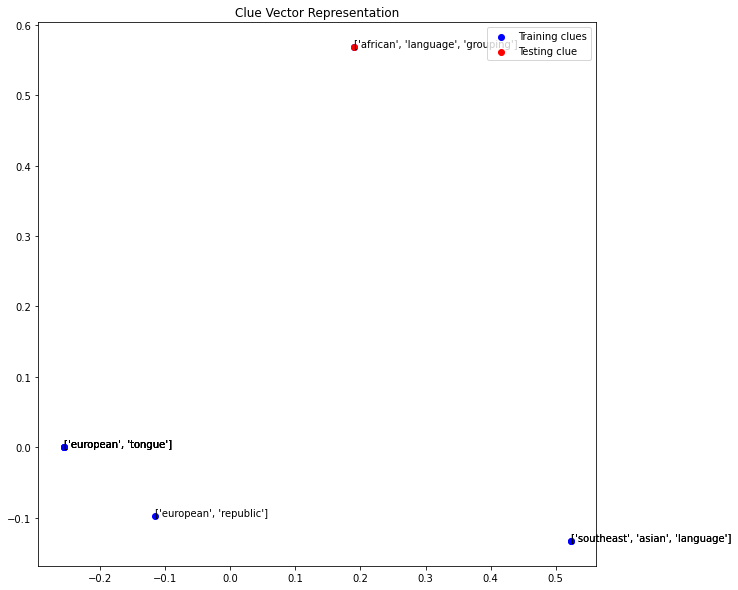

In [118]:
# plotting
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced = pca.fit_transform(vectors)
t = reduced.transpose()
x = t[0]
y = t[1]
fig, axes = plt.subplots(figsize=(10, 10))
plt.scatter(x[0:8], y[0:8], color='blue')
plt.scatter(x[0], y[0], color='red')
for i, txt in enumerate(n_clue):
    plt.annotate(txt, (x[i], y[i]))
plt.title('Clue Vector Representation')
plt.legend(('Training clues','Testing clue'))
plt.show()

In [116]:
x[0]
y[0]

0.5685176481551492